(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Stack Overflow

## Introduction 

In this assignment, we will look at some posts on Stack Overflow during the year of 2015 and measure the similarity of users by looking at the types of questions they answer. We will also analyze the creation dates of questions.

## Step 0. Preparation

Before we start working on the notebook, let's make sure that everything is setup properly. You should have downloaded and installed
* [Anaconda](https://store.continuum.io/cshop/anaconda/)
* [Git](http://git-scm.com/downloads)

If you are working from the undergraduate lab (on a linux machine) these are both installed, but you need to follow the instructions [from here](https://github.com/datascience16/lectures/blob/master/Lecture2/Getting-Started.ipynb).



## Step 1. Getting the data

Let's make a sample request to retrieve the questions posted on Stack Exchange on the first day of 2015. Documentation of the Stack Exchange API can be found [here](https://api.stackexchange.com/docs).

Changed the input to a formattable query string so I can reuse it in future parts.

In [ ]:
import requests

start_time = 1420070400 # 01-01-2015 at 00:00:00
end_time   = 1420156800 # 01-02-2015 at 00:00:00

query_string = 'https://api.stackexchange.com/2.2/questions?page={0}&pagesize=100' \
                '&fromdate={1}&todate={2}' \
                '&order=asc&sort=creation&site=stackoverflow'.format(str(1), str(start_time), str(end_time))
        
response = requests.get(query_string)
print response

All dates in the Stack Exchange API are in [unix epoch time](https://en.wikipedia.org/wiki/Unix_time). The format for the request string is specified [here](https://api.stackexchange.com/docs/questions).

We can try to print the response that Stack Exchange returns.

In [ ]:
print response.text

It is not possible to read the raw response. Instead, we need to decode the raw response as JSON and use the `json` library to print it.

In [ ]:
import json

print json.dumps(response.json(), indent=2)

Now we can easily see that the response consists of a list of question items. For each of these items, we get information about its attributes such as its `creation_date`, `answer_count`, `owner`, `title`, etc.

Notice that has_more is true. To get more items, we can [request the next page](https://api.stackexchange.com/docs/paging).

-----------------

## Step 2. Parsing the responses

In this section, we practice some of the basic Python tools that we learned in class and the powerful string handling methods that Python offers. Our goal is to be able to pick the interesting parts of the response and transform them in a format that will be useful to us.

First let's isolate the creation_date in the response. Fill in the rest of the ```print_creation_dates_json()``` function that reads the response and prints the creation dates. Notice that a JSON object is basically a dictionary. **(5 pts)**

In [ ]:
def print_creation_dates_json(response):
    """
    Prints the creation_date of all the questions in the response.
    
    Parameters:
        response: Response object
    """
    for entry in response['items']:
        print entry['creation_date']
    

Write the code that calls the ```print_creation_dates_json()``` function to print out all the creation dates of questions posted on the first day in 2015. Please be aware of Stack Exchange's [rate limit](https://api.stackexchange.com/docs/throttle). **(5 pts)**

Explanation of the following code:

Grabs 1 page at a time and prints all the creation dates on that page, checks for more pages and repeats if there are more pages to do by incrementing the page variable.

In [ ]:
import json
import requests

start_time = 1420070400 # 01-01-2015 at 00:00:00
end_time   = 1420156800 # 01-02-2015 at 00:00:00
page = 1
query_string = 'https://api.stackexchange.com/2.2/questions?page={0}&pagesize=100' \
                '&fromdate={1}&todate={2}' \
                '&order=asc&sort=creation&site=stackoverflow'.format(str(page), str(start_time), str(end_time))

response = requests.get(query_string).json()
print_creation_dates_json(response)

while(response['has_more'] == True):
    page = page + 1
    query_string = 'https://api.stackexchange.com/2.2/questions?page={0}&pagesize=100' \
                '&fromdate={1}&todate={2}' \
                '&order=asc&sort=creation&site=stackoverflow'.format(str(page), str(start_time), str(end_time))
    response = requests.get(query_string).json()
    print_creation_dates_json(response)

Due to time constraints, we have downloaded the [data dump](http://cs-people.bu.edu/kzhao/teaching/stackoverflow-posts-2015.tar.gz) for Stack Overflow's posts in 2015. Note that this file is 10GB. If you don't have space on your computer, you can download it into `/scratch` on one of the machines in the undergrad lab or you can download it onto a USB. You may also want to work with a subset of this data at first, but your solution should be efficient enough to work with the whole dataset. For example, if you call `read()` on this file, you will get a `MemoryError`.

Write a function to parse out the questions posted in 2015. These are posts with `PostTypeId=1`. Make a `pandas DataFrame` with 4 columns: `Id`, `CreationDate`, `OwnerUserId`, and the first tag in `Tags`. Save the `DataFrame` to a file named `question_dataframe.csv`. **(10 pts)**

Explanation of the following code:

Uses the ElementTree library to parse the xml file and create a list of dictionaries with the information needed. Then adds all the data into a DataFrame and saves it as "question_dataframe.csv"

In [1]:
import pandas as pd
import xml.etree.cElementTree as etree

inputs = []

# assuming there exists a file "stackoverflow-posts-2015.xml" in the same directory as this file
tree = etree.parse('stackoverflow-posts-2015.xml')
root = tree.getroot()

for elem in root:
    if elem.get('PostTypeId') == '1':
        tags = elem.get('Tags')
        inputs.append({
                'Id' : elem.get('Id'), 
                'CreationDate' : elem.get('CreationDate'),
                'OwnerUserId' : elem.get('OwnerUserId'), 
                'Tags' : tags[1:tags.index('>')]
            })
df = pd.DataFrame(inputs, columns=['Id', 'CreationDate', 'OwnerUserId', 'Tags'])
df.to_csv('question_dataframe.csv')
        

In [2]:
import pandas

question_df = pandas.read_csv('question_dataframe.csv')
question_df = question_df.drop('Unnamed: 0', axis = 1) # Drop the extra column generated by reading a CSV file
print question_df

               Id             CreationDate  OwnerUserId            Tags
0        27727385  2015-01-01T00:00:58.253      3210431             php
1        27727388  2015-01-01T00:01:43.673       868779      apache-pig
2        27727391  2015-01-01T00:02:32.123      4372672             ios
3        27727393  2015-01-01T00:02:57.983      2482149      sql-server
4        27727394  2015-01-01T00:03:31.337      4263870             php
5        27727396  2015-01-01T00:04:01.407      4409381         android
6        27727406  2015-01-01T00:05:03.773       875317              c#
7        27727407  2015-01-01T00:05:27.167       821742            java
8        27727408  2015-01-01T00:05:34.733      2595033              c#
9        27727409  2015-01-01T00:06:17.720      1815395          apache
10       27727410  2015-01-01T00:06:41.067       541091           mysql
11       27727414  2015-01-01T00:07:28.747      1210038      javascript
12       27727418  2015-01-01T00:07:39.243      3674356         

-----------------

## Step 3. Putting it all together

We are now ready to tackle our original problem. Write a function to measure the similarity of the top 1000 users with the most answer posts. Compare the users based on the types of questions they answer. We will categorize the questions by looking at the first tag in each question. You may choose to implement any one of the similarity/distance measures we discussed in class. Document your findings. **(30pts)**

Note that answers are posts with `PostTypeId=2`. The ID of the question in answer posts is the `ParentId`.

You may find the [sklearn.feature_extraction module](http://scikit-learn.org/stable/modules/feature_extraction.html) helpful.

Explanation of the following code segment:

The xml file is parsed and creates two dictionaries
    1) users - userId : (num of answered posts, [questionIds they answered])
    2) questionToTags - questionId : that questions tag

Then it sorts the users dictionary into a list of the 1000 most active users and the questions they have answered so that entry 0 is the most active user. Using this list, replace the questions with their appropriate tags from the questionToTags dictionary. Compiles a distinct list of all the tags and makes another list with (userIds, {tags: number of answers to that tag}).

Finally the hammingDistance is applied to each user comparing them to all tags to see how many different tags there are and how many topics the top users cover.

Jaccard Distance has also been implemented to compare users to other users and see how similar two users are. The closer to 0 the more similar 2 users are.

In [3]:
from operator import itemgetter
from collections import Counter
import pandas as pd
import xml.etree.cElementTree as etree

def hammingDistance(userAndTags, allTags):
    (id, tags) = userAndTags
    return len(allTags) - len(tags)

def jaccardDistance(user1, user2):
    return format( 1.0 - float(len(user1.intersection(user2))) / float(len(user1.union(user2))), '.2f' )

jaccardDistances = []

def extractData():
    users = {}
    questionToTags = {}
    
    # assuming there exists a file "stackoverflow-posts-2015.xml" in the same directory as this file
    tree = etree.parse('stackoverflow-posts-2015.xml')
    root = tree.getroot()

    '''
    Populates a dictionary users with userId : (count of answer posts, questions posted to)
    Populates a dictionary questionsToTags with their first tag
    '''
    for elem in root:
        if elem.get('PostTypeId') == '2':
            ownerId = elem.get('OwnerUserId')
            if ownerId in users:
                (count, questionIds) = users[ownerId]
                count = count + 1
                if elem.get('ParentId') not in questionIds:
                    questionIds.append(elem.get('ParentId'))
                users[ownerId] = (count, questionIds)
            else:
                users[ownerId] = (1, [elem.get('ParentId')])
        if elem.get('PostTypeId') == '1':
            questionToTags[elem.get('Id')] = elem.get('Tags')[1:elem.get('Tags').index('>')]

    # sorts users into a list based on the number of posts they have
    sortedUsers = sorted(users.iteritems(), key=itemgetter(1), reverse=True)[0:1000]

    # makes a list of (userId, [tags])
    usersAndTags = [(id, [questionToTags.get(questionId) for questionId in questionIds]) for (id, (count, questionIds)) in sortedUsers]
    
    # a list of all the tags and their counts
    allTags = Counter([tag for (id, tags) in usersAndTags for tag in tags])
    
    # makes a list of (userId, [tags and their count occurences])
    usersToTagCounts = [(id, dict(Counter(tags))) for (id, tags) in usersAndTags]
    
    hammingDistances = [hammingDistance(users, allTags) for users in usersToTagCounts]
    for user in usersToTagCounts:
        jaccardDistances.append([jaccardDistance(set(user[1].keys()), set(user2[1].keys())) for user2 in usersToTagCounts])

    print 'Total number of tags = ' + str(len(allTags))
    print 'How many tags a user hasn\'t responded to'
    print hammingDistances
    
    # only printing 1 so ipython doesn't crash from printing 1000 arrays of size 1000
    print '\n User-to-AllOtherUser Jaccard Distances'
    print jaccardDistances[0]

extractData()


Total number of tags = 2362
How many tags a user hasn't responded to
[2313, 1938, 2317, 2347, 2315, 2297, 2329, 2327, 2345, 2356, 2301, 2190, 2352, 2343, 2333, 2352, 2323, 2282, 2306, 2360, 2316, 2325, 2354, 2277, 2323, 2341, 2344, 2323, 2261, 2348, 2351, 2303, 2346, 2341, 2342, 2358, 2304, 2332, 2332, 2308, 2352, 2348, 2340, 2349, 2269, 2337, 2319, 2265, 2346, 2314, 2354, 2316, 2323, 2331, 2264, 2348, 2350, 2361, 2304, 2319, 2354, 2347, 2350, 2321, 2336, 2303, 2225, 2332, 2358, 2339, 2310, 2329, 2297, 2311, 2352, 2331, 2288, 2240, 2329, 2335, 2309, 2344, 2345, 2313, 2320, 2331, 2338, 2302, 2315, 2341, 2326, 2329, 2312, 2318, 2353, 2317, 2319, 2329, 2289, 2282, 2333, 2310, 2353, 2301, 2316, 2335, 2291, 2356, 2358, 2350, 2352, 2346, 2350, 2322, 2301, 2315, 2319, 2346, 2355, 2314, 2352, 2339, 2351, 2292, 2297, 2331, 2292, 2344, 2319, 2323, 2304, 2350, 2311, 2353, 2319, 2331, 2331, 2304, 2307, 2346, 2350, 2352, 2352, 2352, 2329, 2352, 2343, 2293, 2343, 2357, 2276, 2341, 2347, 2329, 2332, 

Analysis of Results:

Hamming Distance: Most of the top 1000 users did not answer questions with over 50 different tags, suggesting that users only answer questions in topics that they are most comfortable with. There were a couple users with lots of topics, the highest being ~20%, but without looking at the topics to see how similar/different they are it is hard to say whether or not they are answering across multiple topics or just very similar tags that could be clustered into one grouping. The results from this Hamming Distance would be a lot more interesting if the ~2300 tags were combined into less than 100 clusters, but that is out of the scope of this project. 

Jaccard Distances: Plotting out all the Jaccard Distances would crash ipython so I only analyzed the top 2  users because they were significantly different. Analysis of top user: the closest matching user had a Jaccard Distance of 0.62, meaning they only shared 38% of tags between themselves. The biggest difference was a Jaccard Distance of .98, only a 2% similarity. The Jaccard Distance between the top user and the second most active user is .93, only 7% similarity, which is why I decided to also analyze the Jaccard Distance for the second user. 

The second user covered a lot more tags than most people. But interestingly, the smallest Jaccard Distance was 0.82, only an 18% similarilty with most people. And some users actually had a distance of 1.0, meaning no overlap, or an insignificant amount. The second most active user probably answered many questions with similar but slightly different tags resulting in a larger number of total tags answered.

Let's plot a subset of the distance matrix. Order the pairwise distance in your distance matrix (excluding the entries along the diagonal) in increasing order and pick user pairs until you have 100 unique users. See [Lecture 3](https://github.com/datascience16/lectures/blob/master/Lecture3/Distance-Functions.ipynb) for examples. **(10 pts)**

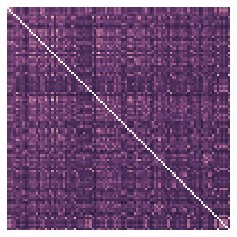

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

similarities = dict()

# makes a dictionary of jaccardDistance : the pair that has that jaccard distance
for i in range(0, len(jaccardDistances)):
    for j in range (0, len(jaccardDistances[0])):
        if similarities.get(jaccardDistances[i][j]) is None:
            similarities[jaccardDistances[i][j]] = [i,j]
        else:
            similarities.get(jaccardDistances[i][j]).append(i)
            similarities.get(jaccardDistances[i][j]).append(j)

            
# remove duplicates
keys = similarities.keys()
for key in keys:
    similarities[key] = set(similarities[key])
    
mostSimilar = set()

# grab 100 most similar
for i in range(1, len(keys)):
    for entry in similarities[keys[i]]:
        if len(mostSimilar) == 100:
            break;
        mostSimilar.add(entry)
        
mostSimilar = sorted(mostSimilar)

distanceMatrix = []

for entry in mostSimilar:
    # make sure inputs are floats so they can be plotted properly.
    distanceMatrix.append([(float)(jaccardDistances[entry][entry2]) for entry2 in mostSimilar])

sns.heatmap(distanceMatrix, xticklabels=False, yticklabels=False, linewidths=0, square=True, cbar=False)

Next, let's create some time series from the data. Look at the top 100 users with the most question posts. For each user, your time series will be the `CreationDate` of the questions posted by that user. You may want to make multiple time series for each user based on the first tag of the questions. Compare the time series using one of the methods discussed in class. Document your findings. **(30 pts)**

You may find the [pandas.DataFrame.resample module](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) helpful.

Explanation of the following code segment:

Euclidean Distance: Standard Euclidean Distance applied to arrays of size 12, 1 for each month.

extractData2: parses the file and makes two dictionaries
    1. UserId : questionIds that they are the author of
    2. QuestionId : (creation date, first tag) where creation date is formatted into [year, month, day]
    
The first dictionary is transformed into a list of (count(number of questions), userId) and sorted from highest to lowest.

From the top 100 of that last a dictionary of Tag : CreationDates is made, and transformed into a dictionary of Tag : Distribution of posts per month, formatted as [jan, feb, ..., nov, dec] with integers in each of the 12 spots. 
The euclidean distance function is applied to each pair of tags to form the distance matrix for our time series data.

In [5]:
from operator import itemgetter
import xml.etree.cElementTree as etree
import operator
import numpy as np

def euclideanDistance(first, second):
    summation = 0
    for i in range(0, len(first)):
        summation = summation + np.square(first[i] - second[i])
    summation = float(summation)
    return format(np.sqrt(summation), '.2f')

def extractData2():
    users = {}
    questionToTimeAndTags = {}
    
    # assuming there exists a file "stackoverflow-posts-2015.xml" in the same directory as this file
    tree = etree.parse('stackoverflow-posts-2015.xml')
    root = tree.getroot()

    '''
    Populates a dictionary users with userId : (questions posted)
    Populates a dictionary questionsToTimeAndtimes with their (creation date, tag) 
        formatted [[year, month, day],...], tag)
    '''
    for elem in root:
        if elem.get('PostTypeId') == '1':
            questionToTimeAndTags[elem.get('Id')] = (elem.get('CreationDate')[0:elem.get('CreationDate').index('T')].split('-'), elem.get('Tags')[1:elem.get('Tags').index('>')])
            if users.get(elem.get('OwnerUserId')) is None:                
                users[elem.get('OwnerUserId')] = [elem.get('Id')]
            else:
                users[elem.get('OwnerUserId')].append(elem.get('Id'))
    
    # a list of (number of question posts, userId)
    users2 = []
    for userId in users.keys():
        users2.append( (len(users[userId]), userId) )
    
    # sort and take the top 100 userId's
    users2 = sorted(users2, reverse=True)
    top100 = []
    for x in range(0,100):
        top100.append(users2[x][1])
    
    # make a dictionary of tag : CreationDates for questions with that tag
    for user in top100:
        for question in users[user]:
            if tagsCreationDates.get(questionToTimeAndTags[question][1]) is None:
                tagsCreationDates[questionToTimeAndTags[question][1]] = [questionToTimeAndTags[question][0]]
            else:
                tagsCreationDates[questionToTimeAndTags[question][1]].append(questionToTimeAndTags[question][0])
    
    # create a distribution for each tag with how many posts a month there were for that tag
    for tag in tagsCreationDates:
        distribution = [0 for x in range(0,12)]
        for dates in tagsCreationDates[tag]:
            distribution[int(dates[1]) - 1] = distribution[int(dates[1]) - 1] + 1
        tagsCreationDates[tag] = distribution

    # make the distance matrix out of euclidean distances
    keys = tagsCreationDates.keys()
    for tags in keys:
        euclideanDistances.append([euclideanDistance(tagsCreationDates[tags], tagsCreationDates[otherTags]) for otherTags in keys])

euclideanDistances = []
tagsCreationDates = {}
extractData2()


Analysis of the results:

There were a lot of very similar results according to the Euclidean Distance formula, but after taking a look at the actual dates the problem was that many tags only had 1 or 2 questions associated with them a year. These small tags are all similar to each other when using this as a metric and will be 'far apart' from anything with any of the other results. When plotting the data in the next part I will filter out all tags that don't have many posts just to get rid of these outliers. The Euclidean Distance for a well-populated tag means a lot more than a tag that is used once or twice.

Plot the 2 most similar and the 2 most different time series. **(10 pts)**

2 Most Similar Time Series
['ruby-on-rails', 'html'] with Euclidean Distance = 90.58
[118, 51, 75, 87, 94, 152, 95, 65, 67, 59, 32, 64]
[81, 56, 72, 109, 95, 93, 72, 84, 97, 62, 58, 45]


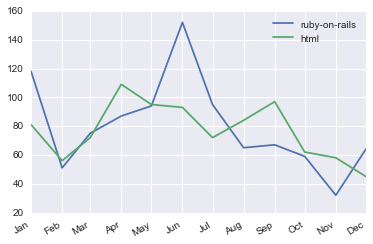

2 Most Different Time Series
['javascript', 'ios'] with Euclidean Distance = 1034.26
[435, 473, 457, 531, 460, 468, 606, 521, 502, 443, 388, 351]
[187, 172, 206, 230, 205, 145, 137, 158, 257, 186, 156, 100]


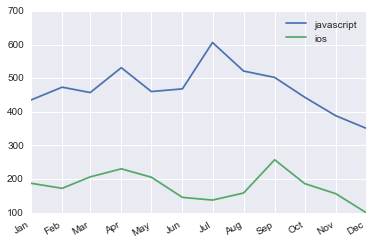

In [6]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from matplotlib.dates import MonthLocator, DateFormatter

%matplotlib inline

def summation(inputList):
    total = 0
    for num in inputList:
        total = total + num
    return total

newTagsAndDates = {}

# get rid of tags that weren't the first tag in more than 250 posts (number picked by checking the set of leftover tags i.e. newTagsAndDates)
for tag in tagsCreationDates:
    if summation(tagsCreationDates[tag]) >= 500:
        newTagsAndDates[tag] = tagsCreationDates[tag]

newEuclideanDistances = []

# make the distance matrix out of euclidean distances
keys = newTagsAndDates.keys()
for tags in keys:
    newEuclideanDistances.append( tuple([euclideanDistance(newTagsAndDates[tags], newTagsAndDates[otherTags]), (tags, otherTags)]  for otherTags in keys))

similarities2 = {}

# makes a dictionary of euclidean distance value : (tag1, tag2)
for tuples in newEuclideanDistances:
    for pair in tuples:
        if similarities2.get(pair[0]) is None:
            similarities2[pair[0]] = []
            similarities2[pair[0]].append(pair[1])
        else:
            similarities2.get(pair[0]).append(pair[1])
            
allKeys = similarities2.keys()
# remove duplicates
keys = similarities2.keys()
for key in keys:
    similarities2[key].sort()
    list(similarities2[key] for similarities2[key],_ in itertools.groupby(similarities2[key]))

# remove all the entries with distance 0.0, all comparisons that are the same
del similarities2[min(list(similarities2))]
    
minDistance = min(list(similarities2))
mins = list(similarities2[min(list(similarities2))])

maxs = list(similarities2[max(list(similarities2))])
maxDistance = max(list(similarities2))

dates = [datetime.date(2015, 1, 1), datetime.date(2015,2,1), datetime.date(2015,3,1), datetime.date(2015,4,1), datetime.date(2015,5,1), datetime.date(2015,6,1), 
         datetime.date(2015,7,1), datetime.date(2015,8,1), datetime.date(2015,9,1), datetime.date(2015,10,1), datetime.date(2015,11,1), datetime.date(2015,12,1)]

'''
Plots the 2 most similar time series data sets on one graph
'''
def plotSimilar():
    print '2 Most Similar Time Series'
    print str(maxs) + ' with Euclidean Distance = ' + str(maxDistance)
    print newTagsAndDates[maxs[0]]
    print newTagsAndDates[maxs[1]]
    months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
    monthsFmt = DateFormatter("%b")
    fig, ax = plt.subplots()
    ax.plot_date(dates, newTagsAndDates[maxs[0]], '-', label=maxs[0])
    ax.plot_date(dates, newTagsAndDates[maxs[1]], '-', label=maxs[1])
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.legend(loc='best')
    plt.show()
    
plotSimilar()


'''
Plots the 2 most different time series data sets on one graph
'''
def plotDifferent():
    print '2 Most Different Time Series'
    print str(mins) + ' with Euclidean Distance = ' + str(minDistance)
    print newTagsAndDates[mins[0]]
    print newTagsAndDates[mins[1]]
    months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
    monthsFmt = DateFormatter("%b")
    fig, ax = plt.subplots()
    ax.plot_date(dates, newTagsAndDates[mins[0]], '-', label=mins[0])
    ax.plot_date(dates, newTagsAndDates[mins[1]], '-', label=mins[1])
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.legend(loc='best')
    plt.show()
    
plotDifferent()

Anaylsis of graphs:

Confirming what was covered in lecture, Euclidean distance doesn't do well to represent time series data, instead of focusing more on the pattern on the data it instead focuses on the distance between the 2 graphs. So something like ios which has few number of posts will be far from javascript which gets a significant amount more. If I had more time I would implement a different metric, such as Dynamic Time Warping, to focus more on the shift in the graph rather than the distance. 

In [8]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()